In [1]:
import JupyterNotebooksLib as slicernb

In [2]:
this_notebook_name = "SpineSegmentationVisualTest"

# place path to scene to test here
scene_to_reconstruct = r"c:\Users\perkl\Documents\AIGT\OneDrive_1_5-12-2020\317_Ax_Ready-ai_done.mrb"

# set this to the name of the model to study
# model_path = r"C:\Users\perkl\Documents\AIGT\aigt\SavedModels\SavedModels\SagittalSpineSegmentationStudy-TF2_model-0_2020-05-11_16-30-08.h5"

In [3]:
slicer.mrmlScene.Clear()
try:
    slicer.util.loadScene(scene_to_reconstruct)
except:
    # NOTE: for some reason loading a scene throws an error every time, but laods the scene just fine
    print('Error thrown. Continuing.')
    

Error thrown. Continuing.


In [4]:
# Find input volume (image) for volume reconstruction

predictionVolume = slicer.mrmlScene.GetFirstNodeByName("PredictionImage")
if predictionVolume is None:
    raise Exception("PredictionImage not found in Slicer scene")

In [5]:
# Create output volume node

reconstructedVolume = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
if reconstructedVolume is None:
    reconstructedVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
    reconstructedVolume.SetName("AiVolume")

In [6]:
inputBrowserNode = slicer.mrmlScene.GetFirstNodeByName("BonePredictionBrowser")
if inputBrowserNode is None:
    raise Exception("BonePredictionBrowser missing")

In [7]:
# Prepare volume reconstructor node

volumeReconstructor = slicer.mrmlScene.GetFirstNodeByName("AiVolumeReconstructor")
if volumeReconstructor is None:
    volumeReconstructor = slicer.vtkMRMLVolumeReconstructionNode()
    volumeReconstructor.SetName("AiVolumeReconstructor")
    volumeReconstructor.SetLiveVolumeReconstruction(False)
    volumeReconstructor.SetOptimizationMode(slicer.vtkMRMLVolumeReconstructionNode.FULL_OPTIMIZATION)
    volumeReconstructor.SetCompoundingMode(slicer.vtkMRMLVolumeReconstructionNode.MAXIMUM_COMPOUNDING_MODE)
    volumeReconstructor.SetInterpolationMode(slicer.vtkMRMLVolumeReconstructionNode.LINEAR_INTERPOLATION)
    slicer.mrmlScene.AddNode(volumeReconstructor)

volumeReconstructor.SetAndObserveInputSequenceBrowserNode(inputBrowserNode)
volumeReconstructor.SetAndObserveOutputVolumeNode(reconstructedVolume)
volumeReconstructor.SetAndObserveInputVolumeNode(predictionVolume)

volumeReconstructionLogic = slicer.modules.volumereconstruction.logic()

In [8]:
# Volume reconstruction

volumeReconstructionLogic.ReconstructVolumeFromSequence(volumeReconstructor)


In [9]:
# Volume rendering

# find input volume
aivolumeNode = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
if aivolumeNode is None:
    raise Exception("AiVolume node was never constructed")

In [10]:
# find or build ROI
annotationROINode = slicer.mrmlScene.GetFirstNodeByName("AnnotationROI")
if annotationROINode is None:
    annotationROINode = slicer.vtkMRMLAnnotationROINode()
    annotationROINode.SetName("AnnotationROI")
    slicer.mrmlScene.AddNode(annotationROINode)
    annotationROINode.SetDisplayVisibility(False)

In [11]:
# find or build volume property
propertyPresetNode = slicer.mrmlScene.GetFirstNodeByName("volMR-Default")
if propertyPresetNode is None:
    propertyPresetNode = slicer.vtkMRMLVolumePropertyNode()
    propertyPresetNode.SetName("volMR-Default")
    volumeRenderingLogic = slicer.modules.volumerendering.logic()
    propertyPresetNode.Copy(volumeRenderingLogic.GetPresetByName('MR-Default'))
    slicer.mrmlScene.AddNode(propertyPresetNode)

In [12]:
# build 3D renderer
volumeRenderingLogic = slicer.modules.volumerendering.logic()
displayNode = volumeRenderingLogic.GetFirstVolumeRenderingDisplayNode(aivolumeNode)
if displayNode is None:
    displayNode = slicer.vtkMRMLGPURayCastVolumeRenderingDisplayNode()
    displayNode.SetName("AiVolumeRenderer")
    slicer.mrmlScene.AddNode(displayNode)
    
    aivolumeNode.AddAndObserveDisplayNodeID(displayNode.GetID())
    
    displayNode.SetAndObserveVolumePropertyNodeID(propertyPresetNode.GetID())
    displayNode.SetAndObserveROINodeID(annotationROINode.GetID())
    
displayNode.SetVisibility(True)
    

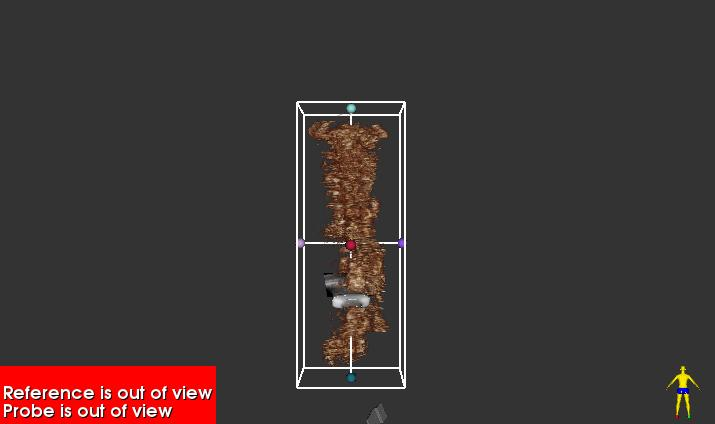

In [13]:
# displaying posterior view
slicernb.View3DDisplay()

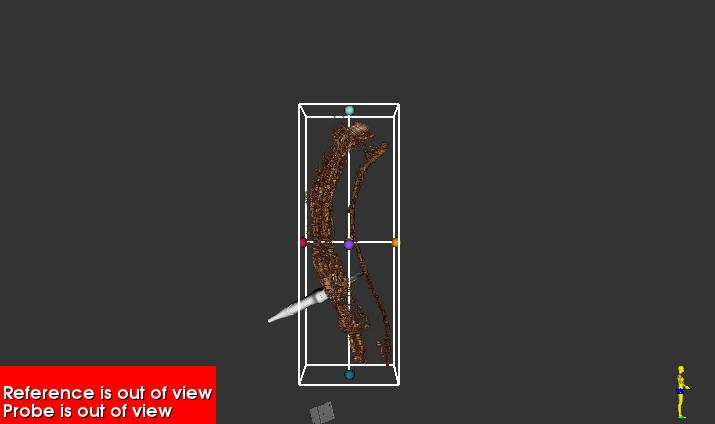

In [14]:
# displaying lateral view
layoutManager = slicer.app.layoutManager()
threeDWidget = layoutManager.threeDWidget(0)
threeDView = threeDWidget.threeDView()

for i in range (0, 18):
    threeDView.yaw()

slicernb.View3DDisplay()